In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
#from tensorflow import keras
from sklearn import preprocessing
from alphavantage_api.AlphaVantageCommodities import AlphaVantageCommodities
from tools.PandasDataFrameNormalizer import PandasDataFrameNormalizer
from dotenv import load_dotenv
import seaborn as sns

load_dotenv()

2023-11-19 19:57:56.288095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 19:57:56.288162: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 19:57:56.288184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 19:57:56.293436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

In [2]:
def tensorflow_use_cpu_only():
    print(tf.__version__)

    # Set CPU as available physical device
    my_devices = tf.config.list_physical_devices(device_type='CPU')
    tf.config.set_visible_devices(devices= my_devices, device_type='CPU')
    
    # To find out which devices your operations and tensors are assigned to
    #tf.debugging.set_log_device_placement(True)

#tensorflow_use_cpu_only()

In [3]:
tf.config.list_physical_devices(device_type=None)

2023-11-19 19:57:58.547284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:57:58.551968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:57:58.552378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


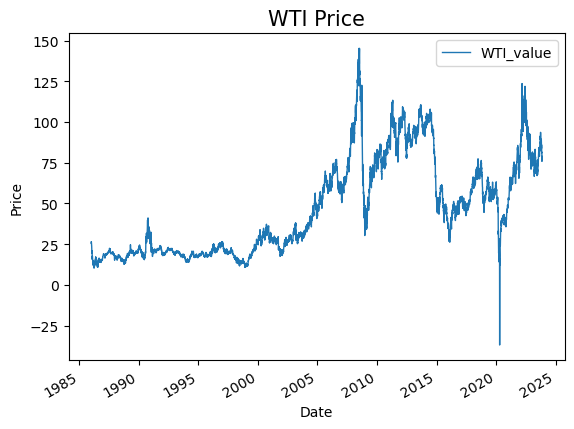

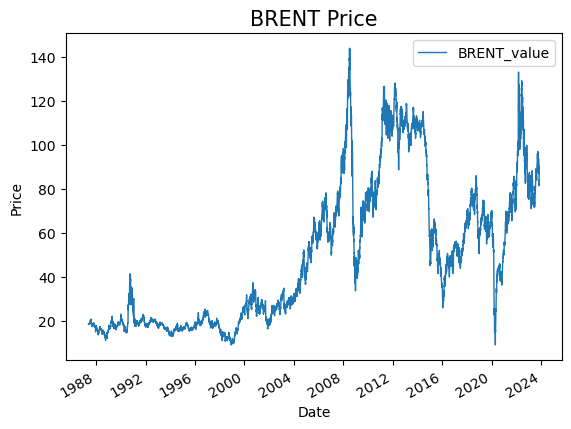

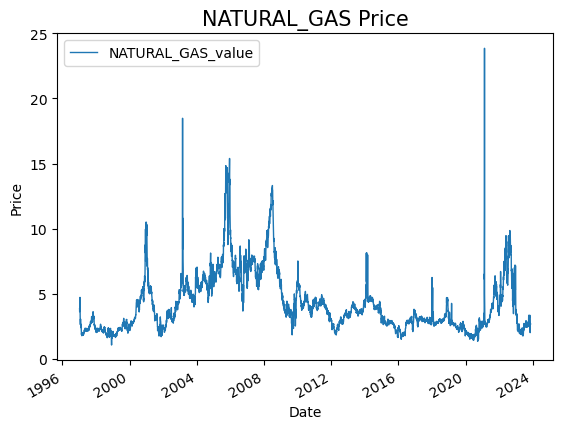

In [5]:
avc = AlphaVantageCommodities()
for symbol in avc.get_all_curated_series_ids():
    avc.plot_series_id(symbol)

In [6]:
df_merged = avc.get_data_as_pandas_df_multiple_series_ids(['WTI','BRENT','NATURAL_GAS'])

In [7]:
df_merged = df_merged.dropna()

<Axes: xlabel='date'>

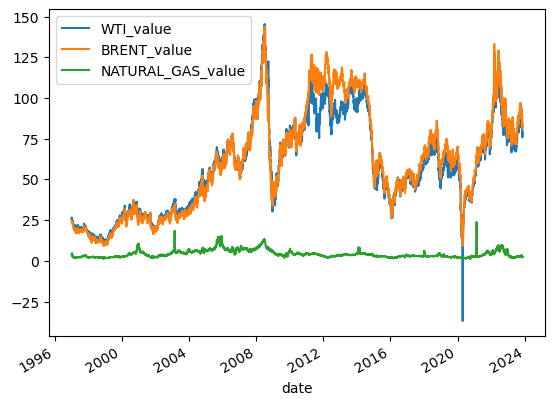

In [8]:
df_merged.plot(x="date")

<Axes: >

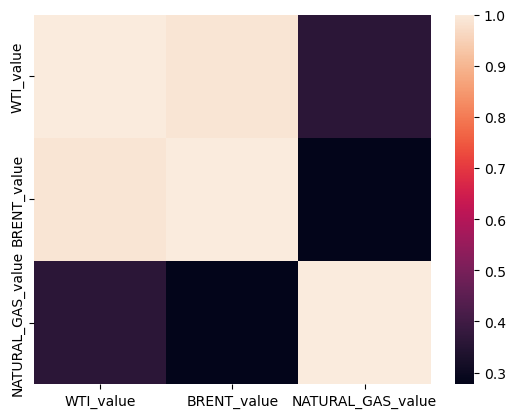

In [9]:
df_corr = df_merged.corr(numeric_only=True)
sns.heatmap(df_corr)

In [10]:
# Normalize data
normalizer_wti = PandasDataFrameNormalizer()
df_normalized = normalizer_wti.normalize_pandas_data_frame_column(df_merged,'WTI_value')

normalizer_brent = PandasDataFrameNormalizer()
df_normalized = normalizer_brent.normalize_pandas_data_frame_column(df_merged,'BRENT_value')

normalizer_natural_gas = PandasDataFrameNormalizer()
df_normalized = normalizer_natural_gas.normalize_pandas_data_frame_column(df_merged,'NATURAL_GAS_value')

In [11]:
df_normalized.tail()

,date,WTI_value,BRENT_value,NATURAL_GAS_value
9534,2023-11-06,0.650173,0.579978,0.072775
9535,2023-11-07,0.630534,0.551205,0.041648
9536,2023-11-08,0.618959,0.536596,0.049540
9537,2023-11-09,0.621647,0.538673,0.072775
9538,2023-11-13,0.635471,0.556099,0.068391


<Axes: xlabel='date'>

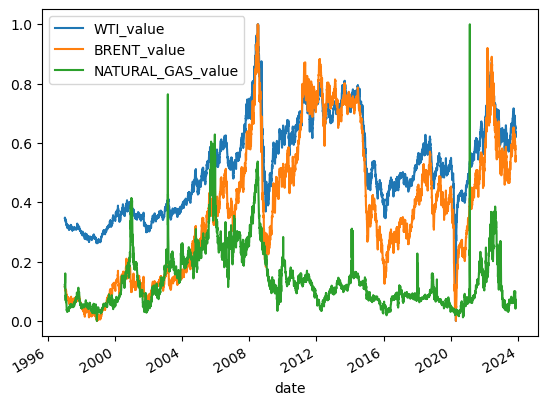

In [12]:
df_normalized.plot(x="date")

In [13]:
data = df_normalized[['WTI_value','BRENT_value','NATURAL_GAS_value']].to_numpy()
data

array([[0.3468649 , 0.11612904, 0.12143796],
       [0.34851062, 0.11627735, 0.12056115],
       [0.34713918, 0.11664813, 0.11223147],
       ...,
       [0.61895883, 0.53659624, 0.04953968],
       [0.6216468 , 0.5386726 , 0.0727751 ],
       [0.6354709 , 0.5560994 , 0.06839105]], dtype=float32)

In [14]:
data.size

19983

In [15]:
np.shape(data)

(6661, 3)

In [16]:
print('Data lenght: ' + str(len(data)))

Data lenght: 6661


In [17]:
left_size = 0.8
split_at = int(left_size * len(data))
print('Split at: ' + str(split_at))

Split at: 5328


In [18]:
forecasting_label_steps = 10
feature_sequence_length = 100

x_train = data[0:split_at]
x_train_data = x_train[:-(feature_sequence_length+forecasting_label_steps)]
x_train_targets = x_train[feature_sequence_length+forecasting_label_steps:, 0]

x_test = data[split_at+1:]
x_test_data = x_test[:-(feature_sequence_length+forecasting_label_steps)]
x_test_targets = x_test[feature_sequence_length+forecasting_label_steps:, 0]

In [19]:
len(x_train_data)

5218

In [20]:
len(x_train_targets)

5218

In [21]:
len(x_test_data)

1222

In [22]:
x_train_data[100:,0]

array([0.3142246 , 0.3114817 , 0.3070931 , ..., 0.53113174, 0.5345329 ,
       0.5340392 ], dtype=float32)

In [23]:
x_train_targets

array([0.3065445 , 0.30572167, 0.3048988 , ..., 0.5670086 , 0.56838006,
       0.56991607], dtype=float32)

In [24]:
dataset_train = tf.keras.utils.timeseries_dataset_from_array(x_train_data, x_train_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=100)

2023-11-19 19:58:00.137079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:58:00.137374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:58:00.137614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:58:00.443293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-19 19:58:00.443617: I tensorflow/compile

In [25]:
#for inputs, targets in dataset_train:
#  print("Input:", inputs.numpy(), "Target:", targets.numpy())

In [26]:
dataset_test = tf.keras.utils.timeseries_dataset_from_array(x_test_data, x_test_targets, sequence_length=feature_sequence_length, sampling_rate=1, batch_size=100)

In [27]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (100, 100, 3)
Target shape: (100,)


In [28]:
#layer_inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#layer_lstm_1 = keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.1)(layer_inputs)
#layer_lstm_2 = keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.1)(layer_lstm_1)
#layer_lstm_out = keras.layers.LSTM(64)(layer_lstm_1)
#layer_outputs = keras.layers.Dense(1)(layer_lstm_out)

#model = keras.Model(inputs=layer_inputs, outputs=layer_outputs)
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
#model.summary()

In [29]:
model = Sequential()

model.add(InputLayer(input_shape = (inputs.shape[1], inputs.shape[2])))

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.1))

model.add(LSTM(units = 200, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units = 200, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          41600     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 200)          240800    
                                                                 
 dropout_1 (Dropout)         (None, 100, 200)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 200)          320800    
                                                                 
 dropout_2 (Dropout)         (None, 100, 200)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 100)          1

In [30]:
path_checkpoint = "model_multi_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

In [31]:
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [32]:
history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100


2023-11-19 19:58:06.478377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-19 19:58:07.537664: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0a2c27b410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-19 19:58:07.537719: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-11-19 19:58:07.542017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-19 19:58:07.622083: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/52 [============================>.] - ETA: 0s - loss: 0.0187 - mean_absolute_error: 0.1061
Epoch 1: val_loss improved from inf to 0.01354, saving model to model_multi_checkpoint.h5
52/52 [==============================] - 10s 77ms/step - loss: 0.0187 - mean_absolute_error: 0.1062 - val_loss: 0.0135 - val_mean_absolute_error: 0.1006
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0543
Epoch 2: val_loss improved from 0.01354 to 0.00775, saving model to model_multi_checkpoint.h5
52/52 [==============================] - 3s 55ms/step - loss: 0.0052 - mean_absolute_error: 0.0544 - val_loss: 0.0078 - val_mean_absolute_error: 0.0728
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0505
Epoch 3: val_loss improved from 0.00775 to 0.00535, saving model to model_multi_checkpoint.h5
52/52 [==============================] - 3s 56ms/step - loss: 0.0046 - mean_absolute_error: 0.0506 - val_loss: 

<Axes: >

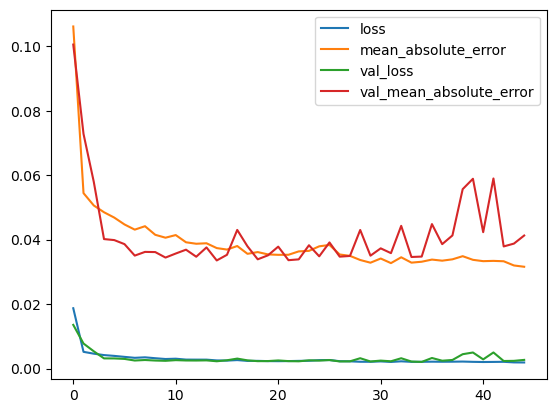

In [33]:
pd.DataFrame(history.history).plot()

In [34]:
model.load_weights(path_checkpoint)
# Re-evaluate the model
loss, acc = model.evaluate(dataset_test, verbose=2)

12/12 - 0s - loss: 0.0020 - mean_absolute_error: 0.0347 - 283ms/epoch - 24ms/step


In [35]:
def plot(input_data, predicted_data, output_compare, limit_right=None):
    if limit_right is not None:
        input_data = input_data[:limit_right]
        predicted_data = predicted_data[:limit_right]
        output_compare = output_compare[:limit_right]
        
    compare_y_shift = feature_sequence_length + forecasting_label_steps
    compare_y = list(range(compare_y_shift, compare_y_shift+ len(output_compare)))
    
    predicted_y_shift = feature_sequence_length + forecasting_label_steps
    predicted_y = list(range(predicted_y_shift, predicted_y_shift + len(predicted_data)))
    
    #input_data_limit = feature_sequence_length

    plt.figure(figsize=(20,6))
    plt.plot(input_data, label = "past", linestyle = 'dashed')
    plt.plot(predicted_y, predicted_data, label = "predicted")
    plt.plot(compare_y, output_compare, label = "real data", linestyle = 'dotted')
    plt.plot(feature_sequence_length, input_data[feature_sequence_length-1], "rx", label = "start prediction")
    plt.legend()
    plt.show()

In [36]:
for x, y in dataset_test.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [37]:
for x, y in dataset_train.take(0):
    #print(x)
    #print(y)
    predicted_data = normalizer_wti.inverse_transform_numpy_array(model.predict(x.numpy()))
    #input_data = list(x.as_numpy_iterator())[0][0][:, 1]
    #print(x[:,0,0])
    input_data = normalizer_wti.inverse_transform_numpy_array(x[:, 0, 0].numpy())
    #print("input")
    #print(input_data)
    #output_compare = list(x.as_numpy_iterator())[0][1]
    output_compare = normalizer_wti.inverse_transform_numpy_array(y.numpy())
    #print("output")
    #print(output_compare)
    plot(input_data, predicted_data, output_compare)

In [38]:
# https://medium.com/@prajjwalchauhan94017/stock-prediction-and-forecasting-using-lstm-long-short-term-memory-9ff56625de73

In [39]:
predicted_dataset_train = model.predict(dataset_train)

52/52 [==============================] - 2s 19ms/step


In [40]:
len(predicted_dataset_train)

5119

In [41]:
len(predicted_dataset_train[:,0])

5119

In [42]:
x_train_data[:,0]

array([0.3468649 , 0.34851062, 0.34713918, ..., 0.53113174, 0.5345329 ,
       0.5340392 ], dtype=float32)

In [43]:
# inverse transforms
normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0])
normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0])
normalizer_wti.inverse_transform_numpy_array(x_train_targets)

array([18.899998, 18.75    , 18.600002, ..., 66.37999 , 66.630005,
       66.91    ], dtype=float32)

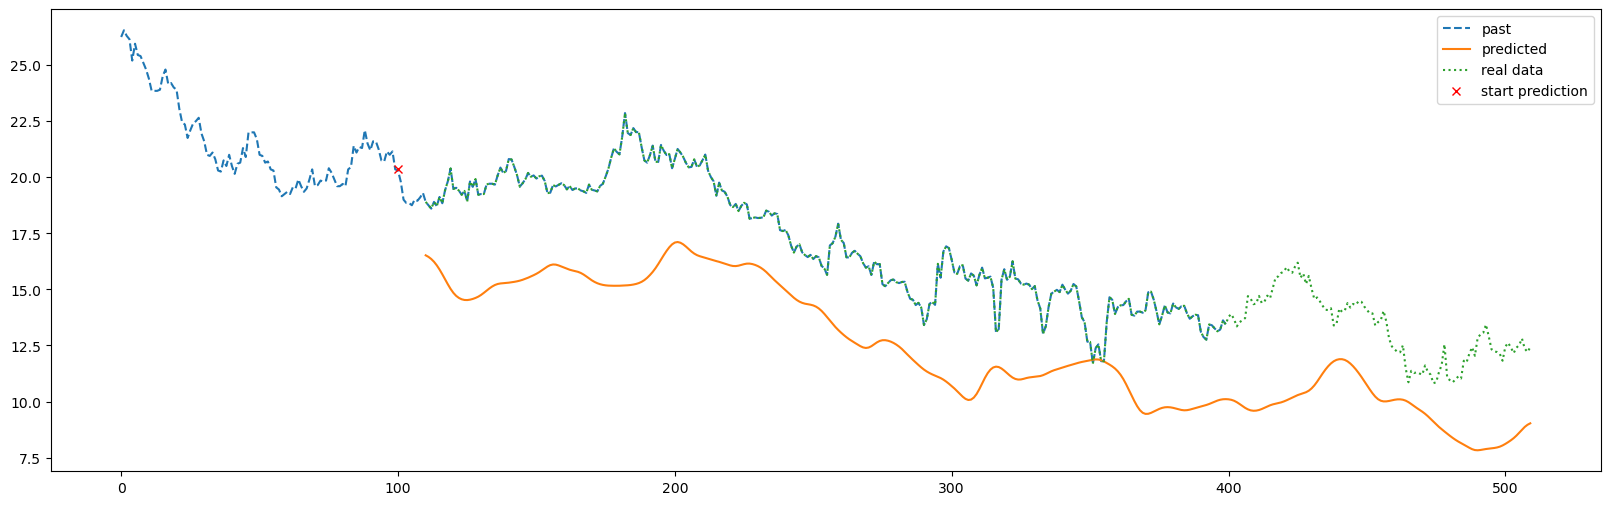

In [44]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_train_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_train[:,0]), 
    normalizer_wti.inverse_transform_numpy_array(x_train_targets), 
    limit_right=400
)

In [45]:
predicted_dataset_test = model.predict(dataset_test)

12/12 [==============================] - 0s 20ms/step


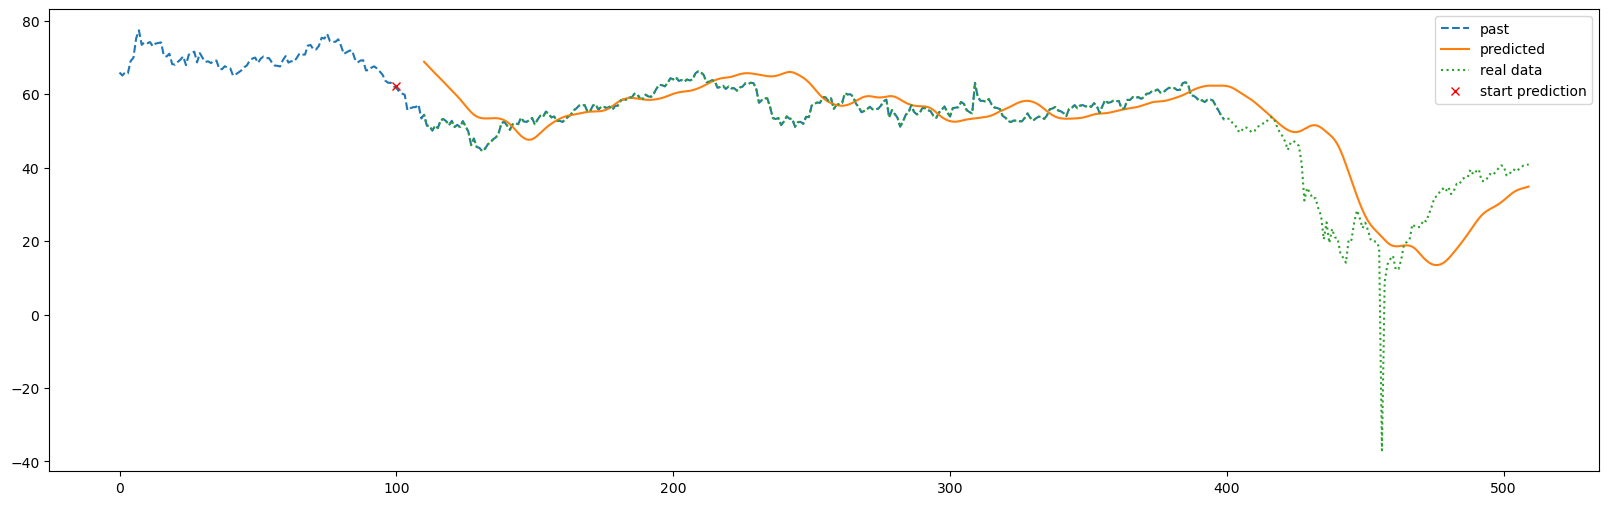

In [46]:
plot(
    normalizer_wti.inverse_transform_numpy_array(x_test_data[:,0]),
    normalizer_wti.inverse_transform_numpy_array(predicted_dataset_test[:,0]), 
    normalizer_wti.inverse_transform_numpy_array(x_test_targets), 
    limit_right=400
)